In [1]:
from argparse import Namespace

from classifier import *
from dataset import *
from vectorizer import *

import torch

/home/nik/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-nix056an because the default path (/home/nik/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Namespace
Here we use a namespace to aggregate all runtime parameters and easily adjust them later on

In [2]:
def use_cuda():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

args = Namespace (
    in_features=None,
    out_units=1,
    dataset=None,
    optimizer="Adam",
    criterion="bce_logits",
    batch_size=128,
    learning_rate=0.001,
    num_epochs=5,
    device=use_cuda(),
    embed_dim=300,
    freeze_embedding=False,
    filter_sizes=[3, 4, 5],
    num_filters=[100, 100, 100],
    pretrained_embedding=None, 
    hidden_size=2, # number of features in hidden state
    num_layers=1, # number of stacked lstm layers,
    save_state_path="../checkpoints",
    save_best_path="../best_models",
    name=""
)

Load the tweets products dataset

In [3]:
args.dataset = TextDataset.load_dataset_and_make_vectorizer("../data/tweets_products.csv")
args.in_features = args.dataset.vectorizer.max_padding
args.name = "BOW-Classifier.pth"

[nltk_data] Downloading package stopwords to /home/nik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Bag of Words Classifier

Initialize a simple neural network which utilizes a bag of words approach to representing the encoded text. 

In [4]:
bow = BOWClassifier(args=args)
bow.setup()
bow.fit()

100%|██████████| 5/5 [28:18<00:00, 339.75s/it]


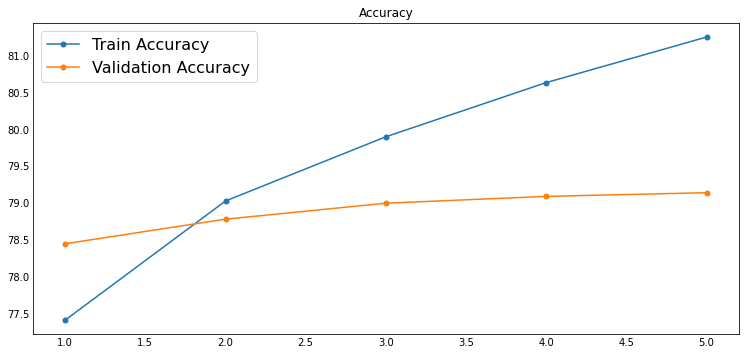

In [5]:
bow.plot_logs("Accuracy", ["Train Accuracy", "Validation Accuracy"])

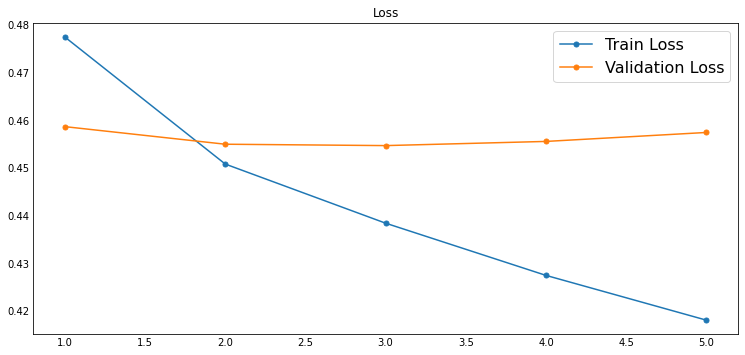

In [6]:
bow.plot_logs("Loss", ["Train Loss", "Validation Loss"])

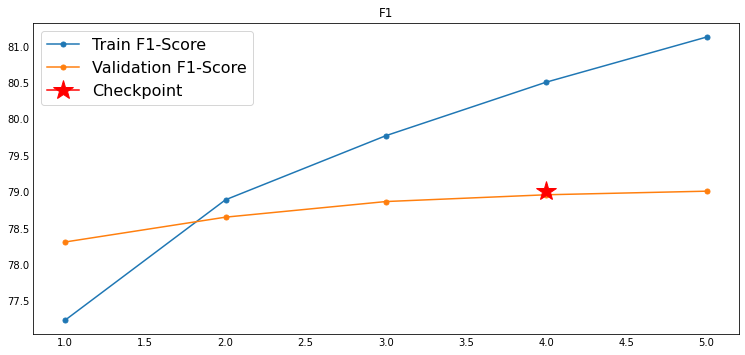

In [7]:
bow.plot_logs("F1", ["Train F1-Score", "Validation F1-Score"])

Evaluate the the bag of words classifier on the tweets products dataset.

In [8]:
bow.load_state()
loss, acc, f1 = bow.eval_net(mode='test')
print(loss)
print(acc)
print(f1)

0.45720862305164317
79.1443749999999
79.00497505537606


Now we load the IMDB dataset and test the above model on that. 
We observed a significant drop in the performance of the model as it can be seen from the output of the current cell.

In [9]:
args.dataset = TextDataset.load_dataset_and_make_vectorizer("../data/IMDB-dataset.csv")
loss, acc, f1 = bow.eval_net(mode='test')
print(loss)
print(acc)
print(f1)

[nltk_data] Downloading package stopwords to /home/nik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


5.51753876148126
51.0917467948718
39.94437855185269


In the next experiments we would like to evaluate the performance of the convolutional neural network on the previous scenario.

In [10]:
args.dataset = TextDataset.load_dataset_and_make_vectorizer("../data/tweets_products.csv", vectorizer_mode="padded")
args.pretrained_embedding = args.dataset.vectorizer.load_pretrained_embed("../data/crawl-300d-2M.vec")
args.name = "CNN-Classifier.pth"

[nltk_data] Downloading package stopwords to /home/nik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
1999995it [00:37, 52646.53it/s]


### Convolutional Neural Network

Setup a CNN classifier, train and validate the network on the tweets products dataset.

In [11]:
cnn_classifier = CNNClassifier(args=args)
cnn_classifier.setup()
cnn_classifier.fit()

100%|██████████| 5/5 [35:08<00:00, 421.74s/it]


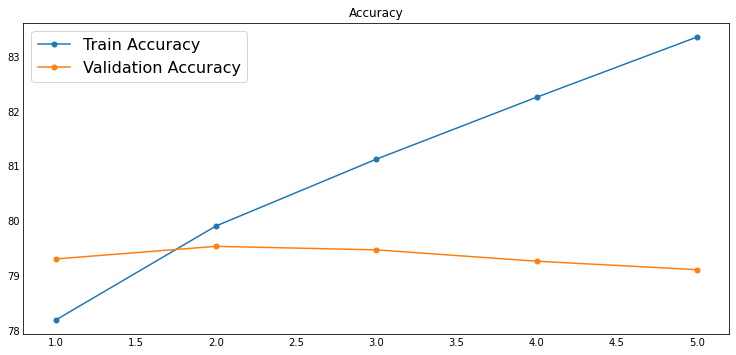

In [12]:
cnn_classifier.plot_logs("Accuracy", ["Train Accuracy", "Validation Accuracy"])

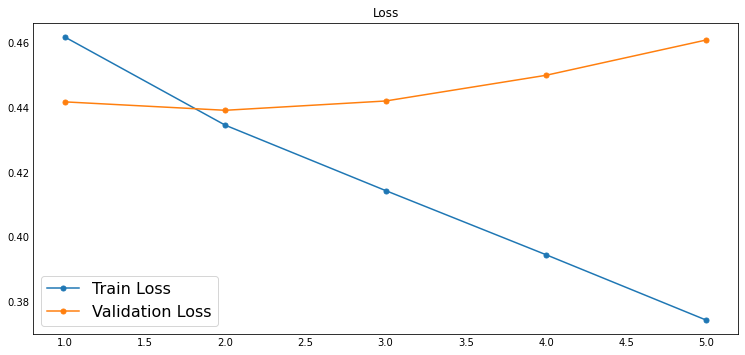

In [13]:
cnn_classifier.plot_logs("Loss", ["Train Loss", "Validation Loss"])

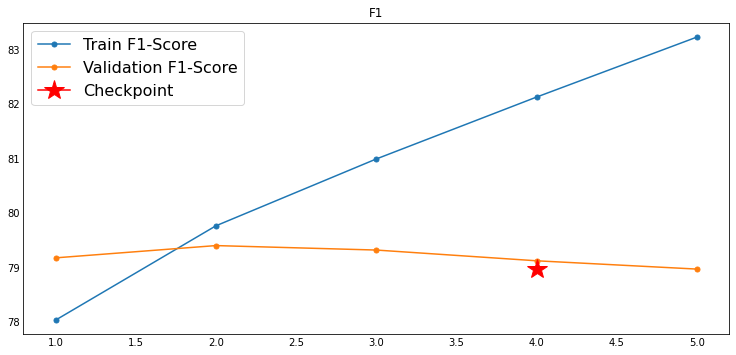

In [14]:
cnn_classifier.plot_logs("F1", ["Train F1-Score", "Validation F1-Score"])

Test CNN on the tweets test set

In [15]:
loss, acc, f1 = cnn_classifier.eval_net(mode='test')
print(loss)
print(acc)
print(f1)

0.46199435331821487
79.0843749999998
78.94002388471431


Evaluate CNN's performance on the IMDB dataset. Again there is decrease on the new test set, although not as significant as in the previous case.

In [16]:
args.dataset = TextDataset.load_dataset_and_make_vectorizer("../data/IMDB-dataset.csv", vectorizer_mode="padded")
embedding = args.dataset.vectorizer.load_pretrained_embed("../data/crawl-300d-2M.vec")
embedding = embedding.to(args.device)
cnn_classifier.embedding = nn.Embedding.from_pretrained (
    embedding,
    freeze=args.freeze_embedding
)
loss, acc, f1 = cnn_classifier.eval_net(mode='test')
print(loss)
print(acc)
print(f1)

[nltk_data] Downloading package stopwords to /home/nik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
1999995it [00:30, 65466.89it/s]


0.6346417191701058
63.39142628205129
61.084001543354375


### LSTM

Use a Long Short-Term Memory network for the previous configuration

In [17]:
args.dataset = TextDataset.load_dataset_and_make_vectorizer("../data/tweets_products.csv", vectorizer_mode="padded")
args.pretrained_embedding = args.dataset.vectorizer.load_pretrained_embed("../data/crawl-300d-2M.vec")
args.name = "LSTM-Classifier.pth"

[nltk_data] Downloading package stopwords to /home/nik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
1999995it [00:51, 38497.29it/s]


In [18]:
lstm_classifier = LSTMClassifier(args)
lstm_classifier.setup()
lstm_classifier.fit()

100%|██████████| 5/5 [47:26<00:00, 569.30s/it]


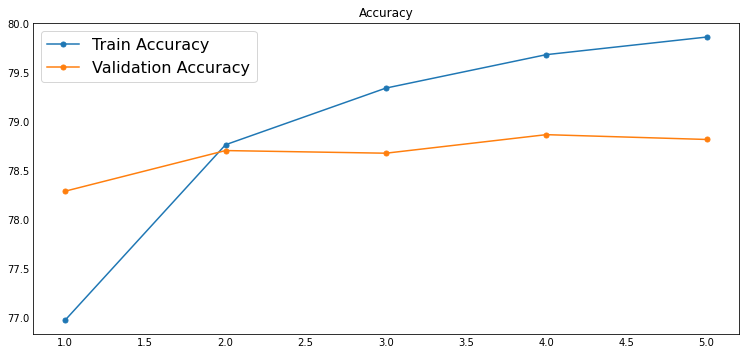

In [19]:
lstm_classifier.plot_logs("Accuracy", ["Train Accuracy", "Validation Accuracy"])

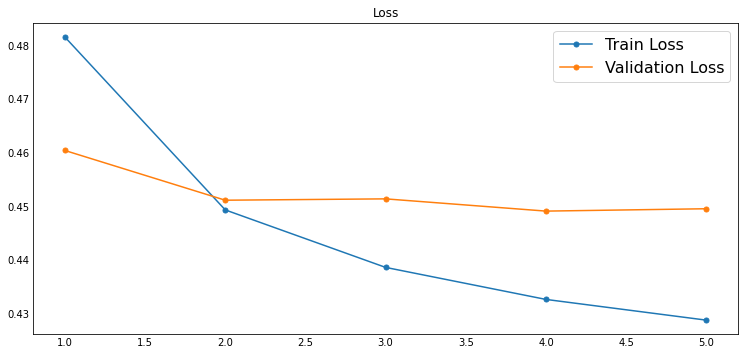

In [20]:
lstm_classifier.plot_logs("Loss", ["Train Loss", "Validation Loss"])

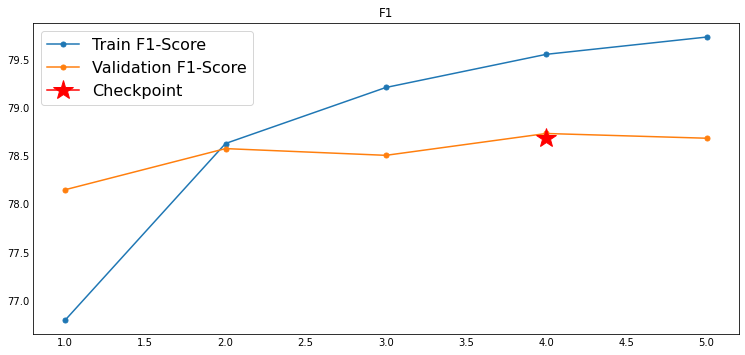

In [21]:
lstm_classifier.plot_logs("F1", ["Train F1-Score", "Validation F1-Score"])

In [22]:
loss, acc, f1 = lstm_classifier.eval_net(mode='test')
print(loss)
print(acc)
print(f1)

0.44889613534212164
78.88218750000003
78.73423169497433


In [23]:
args.dataset = TextDataset.load_dataset_and_make_vectorizer("../data/IMDB-dataset.csv", vectorizer_mode="padded")
embedding = args.dataset.vectorizer.load_pretrained_embed("../data/crawl-300d-2M.vec")
embedding = embedding.to(args.device)
lstm_classifier.embedding = nn.Embedding.from_pretrained (
    embedding,
    freeze=args.freeze_embedding
)

[nltk_data] Downloading package stopwords to /home/nik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
1999995it [00:48, 41228.78it/s]


In [24]:
loss, acc, f1 = lstm_classifier.eval_net(mode='test')
print(loss)
print(acc)
print(f1)

0.6533463582014424
61.01762820512822
60.34306565473385
